In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import struct

import cartopy
from cartopy import crs as ccrs
import matplotlib 
from matplotlib import pyplot as plt
import os
from os.path import join, exists
from os import mkdir
import scipy
import netCDF4
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
import pandas as pd
import matplotlib.path as mpath
from matplotlib.colors import TwoSlopeNorm 

time_scale=86400/2/np.pi
length_scale=6370*1000
PSI_scale=length_scale**2/time_scale

with open("/scratch/hz1994/blocking/data_MMmodel/filepath.txt","r") as fi:
    for ln in fi:
        if ln.startswith("dimensionalized_filepath"):
            dim_path=ln.strip().split('\t')[1]
        if ln.startswith("TMindex_filepath"):
            TMindex_path=ln.strip().split('\t')[1]  
        if ln.startswith("nondimensionalized_filepath"):
            nondim_path=ln.strip().split('\t')[1]
        if ln.startswith("DGindex_filepath"):
            DGindex_path=ln.strip().split('\t')[1]  
        if ln.startswith("fig_filepath" ):
            fig_path=ln.strip().split('\t')[1]  
print(dim_path)
print(nondim_path)
print(TMindex_path)
print(DGindex_path)
print(fig_path)


/ext3/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/scratch/hz1994/blocking/data_MMmodel/dim/
/scratch/hz1994/blocking/data_MMmodel/nondim/
/scratch/hz1994/blocking/data_MMmodel/TMindex/
/scratch/hz1994/blocking/data_MMmodel/DGindex/
/scratch/hz1994/blocking/data_MMmodel/fig_MMmodel/


# Compute composite of T>=5 and T=0 for MM model

In [ ]:
Z500=xr.open_dataarray(dim_path+"dim_Z500_1250k_lowpass3dys.nc" )
Tk=xr.open_dataarray(DGindex_path+"Atl_Tk_1250k_lowpass3dys.nc")


Z500=Z500.sel(latitude=slice(20,90))
std_z=Z500.std(dim='time')
mean_z=Z500.mean(dim='time')
std_z.to_netcdf(fig_path+"std_z.nc")
mean_z.to_netcdf(fig_path+"mean_z.nc")
blocking_composite=Z500[Tk>=5].mean(dim="time")
non_blocking_composite=Z500[Tk==0].mean(dim="time")
latitudes=Z500.latitude.sel(latitude=slice(20,90))
longitudes=Z500.longitude
latitudes.to_netcdf(fig_path+"latitudes.nc")
longitudes.to_netcdf(fig_path+"longitudes.nc")
blocking_composite.to_netcdf(fig_path+"blocking_composite_MM.nc")
non_blocking_composite.to_netcdf(fig_path+"non_blocking_composite.nc")


# Compute blocking statistics for MMmodel

In [4]:
def IB2duration(lsbyear,day): #5 days duration criteria
    start=lsbyear.copy(deep=True)
    for i in range(day): # identify the points with the forward 1,2,3,4 being true (within LSB). notice we pad the shift by false at the end since a blocking event cannot start there (<5days)
        start=start & lsbyear.shift(time=-i,fill_value=False)
    event=start.copy(deep=True) # include the points forward 1,2,3,4 
    for i in range(day):
        event=event | start.shift(time=i,fill_value=False)
    return event
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s} " if plt.rcParams["text.usetex"] else f"{s} "

zprime=xr.open_dataarray(dim_path+"dim_Zprime500_1250k_lowpass3dys.nc" )

M=100
T=5 

zprime=zprime.sel(latitude=slice(20,90))
IB_positive=zprime>=M
blockings_positive=IB2duration(IB_positive,T)
mean=blockings_positive.mean(dim='time')
start=(((blockings_positive.data[1:])*1-(blockings_positive.data[:-1])*1)==1).sum(axis=0)
pltstart=mean.copy(deep=True,data=start)

num_MM=pltstart
percent_MM=mean*100 
num_MM.to_netcdf(fig_path+"num_MM.nc")
percent_MM.to_netcdf(fig_path+"percent_MM.nc")

# Compute blocking statistics for ERA5

In [ ]:
ds_all=xr.open_dataset("/scratch/hz1994/blocking/DG/1959-2021_data/1959-2021-integrate-ds_new.nc")
dsanomalies=ds_all['gh'].groupby('time.dayofyear')-ds_all['gh'].groupby('time.dayofyear').mean()
scale=1/np.sin(dsanomalies.coords['latitude']*np.pi/180)*np.sin(45*np.pi/180)
zprime=(dsanomalies*scale).sel(latitude=np.arange(20,90+2.5,2.5))
startyear=1959
endyear=2021

M=150
T=5

DJF=True
strDJF=DJF*'DJF'
if DJF:
    zprime=zprime.sel(time=slice(str(startyear)+'-12-01',str(endyear)+'-03-01'))
    zprime=zprime.sel(time=zprime.time.dt.month.isin([12,1,2]))
else:
    zprime=zprime.sel(time=slice(str(startyear),str(endyear)))

IB_positive=zprime>=M
IB_negative=zprime<-M
IB_both=IB_positive|IB_negative
blockings_positive=IB2duration(IB_positive,T)
blockings_negative=IB2duration(IB_negative,T)
blockings_both=IB2duration(IB_both,T)

start=(((blockings_positive.data[1:])*1-(blockings_positive.data[:-1])*1)==1).sum(axis=0)
pltstart=blockings_positive.mean(dim='time').copy(deep=True,data=start)

num_era5=pltstart
percent_era5=blockings_positive.mean(dim='time')*100

num_era5.to_netcdf(fig_path+"num_blocking_era5.nc")
percent_era5.to_netcdf(fig_path+"percent_blocking_era5.nc")

In [1]:
import xarray as xr

# Define the file path
file_path = '/scratch/negishi/yan481/blockings_era5_DG_M150_T5'

# Load the NetCDF file as an xarray Dataset
ds = xr.open_dataset(file_path)

# Print out information about the Dataset
print(ds)


/home/yan481/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/yan481/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


<xarray.Dataset> Size: 2GB
Dimensions:                        (latitude: 29, time: 23011, longitude: 144)
Coordinates:
  * latitude                       (latitude) float64 232B 20.0 22.5 ... 90.0
  * time                           (time) datetime64[ns] 184kB 1959-01-01 ......
  * longitude                      (longitude) float64 1kB -180.0 ... 177.5
    dayofyear                      (time) int64 184kB ...
    A                              (time, latitude, longitude) float64 769MB ...
    B                              (time, latitude, longitude) float64 769MB ...
Data variables:
    __xarray_dataarray_variable__  (time, latitude, longitude) bool 96MB ...


In [2]:
# Print detailed information about the Dataset
ds.info()


xarray.Dataset {
dimensions:
	latitude = 29 ;
	time = 23011 ;
	longitude = 144 ;

variables:
	float64 latitude(latitude) ;
		latitude:standard_name = latitude ;
		latitude:long_name = latitude ;
		latitude:units = degrees_north ;
		latitude:axis = Y ;
	datetime64[ns] time(time) ;
		time:standard_name = time ;
		time:axis = T ;
	float64 longitude(longitude) ;
		longitude:standard_name = longitude ;
		longitude:long_name = longitude ;
		longitude:units = degrees_east ;
		longitude:axis = X ;
	int64 dayofyear(time) ;
	float64 A(time, latitude, longitude) ;
	float64 B(time, latitude, longitude) ;
	bool __xarray_dataarray_variable__(time, latitude, longitude) ;

// global attributes:
}

In [3]:
# List all variables with their attributes
for var_name in ds.variables:
    print(ds[var_name])


<xarray.DataArray 'latitude' (latitude: 29)> Size: 232B
array([20. , 22.5, 25. , 27.5, 30. , 32.5, 35. , 37.5, 40. , 42.5, 45. , 47.5,
       50. , 52.5, 55. , 57.5, 60. , 62.5, 65. , 67.5, 70. , 72.5, 75. , 77.5,
       80. , 82.5, 85. , 87.5, 90. ])
Coordinates:
  * latitude  (latitude) float64 232B 20.0 22.5 25.0 27.5 ... 85.0 87.5 90.0
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y
<xarray.DataArray 'time' (time: 23011)> Size: 184kB
array(['1959-01-01T00:00:00.000000000', '1959-01-02T00:00:00.000000000',
       '1959-01-03T00:00:00.000000000', ..., '2021-12-29T00:00:00.000000000',
       '2021-12-30T00:00:00.000000000', '2021-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 184kB 1959-01-01 1959-01-02 ... 2021-12-31
    dayofyear  (time) int64 184kB ...
Attributes:
    standard_name:  time
    axis:           T
<xarray.DataArray 'longitude' (long

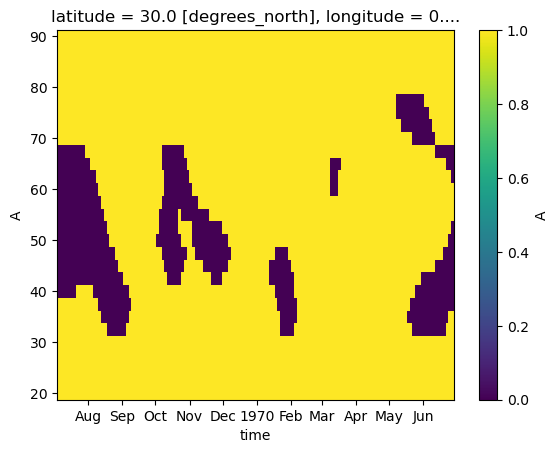

In [4]:
# Plot a single time slice of 'A'
ds['A'].isel(time=0).plot()

# Plot the temporal evolution of 'A' at a specific latitude and longitude
ds['A'].sel(latitude=30.0, longitude=0.0).plot()


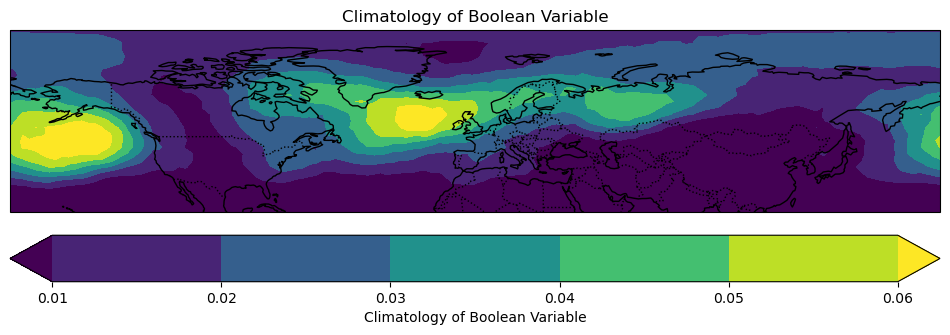

In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the dataset
file_path = '/scratch/negishi/yan481/blockings_era5_DG_M150_T5'
ds = xr.open_dataset(file_path)

# Calculate the climatology by averaging over time
climatology = ds['__xarray_dataarray_variable__'].mean(dim='time')

# Create a plot
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the climatology
contour = ax.contourf(ds['longitude'], ds['latitude'], climatology,
                      transform=ccrs.PlateCarree(), cmap='viridis', extend='both')

# Add coastlines and features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)

# Add a colorbar
cbar = plt.colorbar(contour, orientation='horizontal', pad=0.05)
cbar.set_label('Climatology of Boolean Variable')

# Set title
ax.set_title('Climatology of Boolean Variable')

# Show the plot
plt.show()


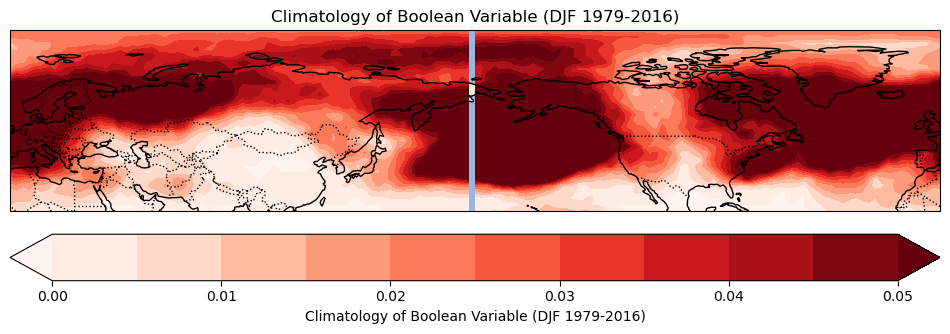

In [9]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Load the dataset
file_path = '/scratch/negishi/yan481/blockings_era5_DG_M150_T5'
ds = xr.open_dataset(file_path)

# Select the DJF season data from 1979 to 2016
ds_djf = ds.sel(time=((ds['time'].dt.year >= 1979) & (ds['time'].dt.year <= 2016) &
                      ((ds['time'].dt.month == 12) | (ds['time'].dt.month == 1) | (ds['time'].dt.month == 2))))

# Calculate the climatology by averaging over time
climatology = ds_djf['__xarray_dataarray_variable__'].mean(dim='time')

# Create a plot centered at 180° longitude
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# Plot the climatology with cmap restricted to 0-0.05 using Reds colormap
contour = ax.contourf(ds['longitude'], ds['latitude'], climatology,
                      transform=ccrs.PlateCarree(), cmap='Reds', levels=np.linspace(0, 0.05, 11), extend='both')

# Add coastlines and features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)

# Add a colorbar
cbar = plt.colorbar(contour, orientation='horizontal', pad=0.05)
cbar.set_label('Climatology of Boolean Variable (DJF 1979-2016)')

# Set title
ax.set_title('Climatology of Boolean Variable (DJF 1979-2016)')

# Show the plot
plt.show()


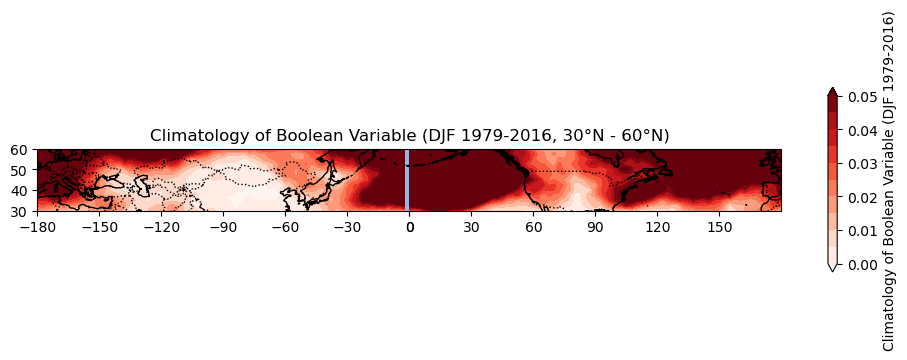

In [17]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Load the dataset
file_path = '/scratch/negishi/yan481/blockings_era5_DG_M150_T5'
ds = xr.open_dataset(file_path)

# Select the DJF season data from 1979 to 2016
ds_djf = ds.sel(time=((ds['time'].dt.year >= 1979) & (ds['time'].dt.year <= 2016) &
                      ((ds['time'].dt.month == 12) | (ds['time'].dt.month == 1) | (ds['time'].dt.month == 2))))

# Restrict to latitude range 30N to 60N
ds_djf = ds_djf.sel(latitude=slice(30, 60))

# Calculate the climatology by averaging over time
climatology = ds_djf['__xarray_dataarray_variable__'].mean(dim='time')

# Create a plot centered at 180° longitude
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# Plot the climatology with cmap restricted to 0-0.05 using Reds colormap
contour = ax.contourf(ds_djf['longitude'], ds_djf['latitude'], climatology,
                      transform=ccrs.PlateCarree(), cmap='Reds', levels=np.linspace(0, 0.05, 11), extend='both')

# Add coastlines and features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)

# Add a vertical colorbar, shrink it to make it shorter
cbar = plt.colorbar(contour, orientation='vertical', pad=0.05, shrink=0.4)  # Adjust shrink to control height
cbar.set_label('Climatology of Boolean Variable (DJF 1979-2016)')

# Set latitude and longitude labels
ax.set_xticks(np.arange(-180, 181, 30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(30, 61, 10), crs=ccrs.PlateCarree())
# ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°E' if x >= 0 else f'{int(x)}°W'))
# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°N'))

# Set gridlines
# ax.gridlines(draw_labels=False)

# Set title
ax.set_title('Climatology of Boolean Variable (DJF 1979-2016, 30°N - 60°N)')

# Show the plot
plt.show()


/home/yan481/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/yan481/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


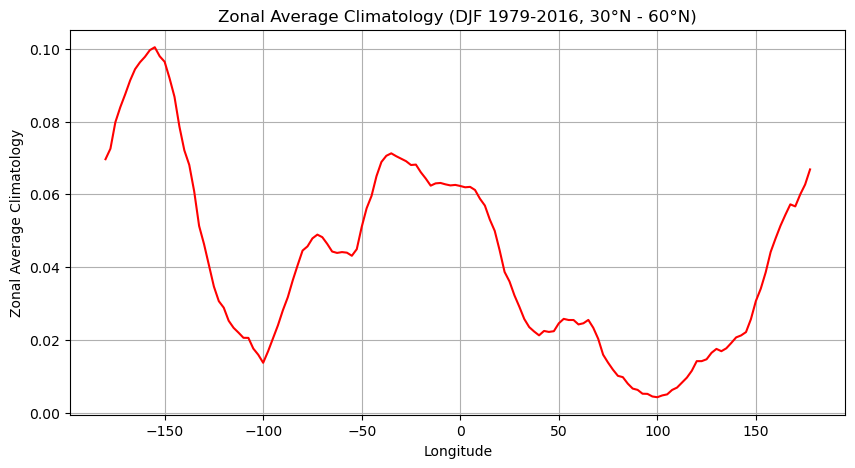

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
file_path = '/scratch/negishi/yan481/blockings_era5_DG_M150_T5'
ds = xr.open_dataset(file_path)

# Select the DJF season data from 1979 to 2016
ds_djf = ds.sel(time=((ds['time'].dt.year >= 1979) & (ds['time'].dt.year <= 2016) &
                      ((ds['time'].dt.month == 12) | (ds['time'].dt.month == 1) | (ds['time'].dt.month == 2))))

# Restrict to latitude range 30N to 60N
ds_djf = ds_djf.sel(latitude=slice(30, 60))

# Calculate the climatology by averaging over time
climatology = ds_djf['__xarray_dataarray_variable__'].mean(dim='time')

# Calculate the zonal average (average over latitude)
zonal_avg = climatology.mean(dim='latitude')

# Create a plot of the zonal average
plt.figure(figsize=(10, 5))

# Plot the zonal average
plt.plot(ds_djf['longitude'], zonal_avg, color='red')

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Zonal Average Climatology')
plt.title('Zonal Average Climatology (DJF 1979-2016, 30°N - 60°N)')

# Show grid
plt.grid(True)

# Show the plot
plt.show()


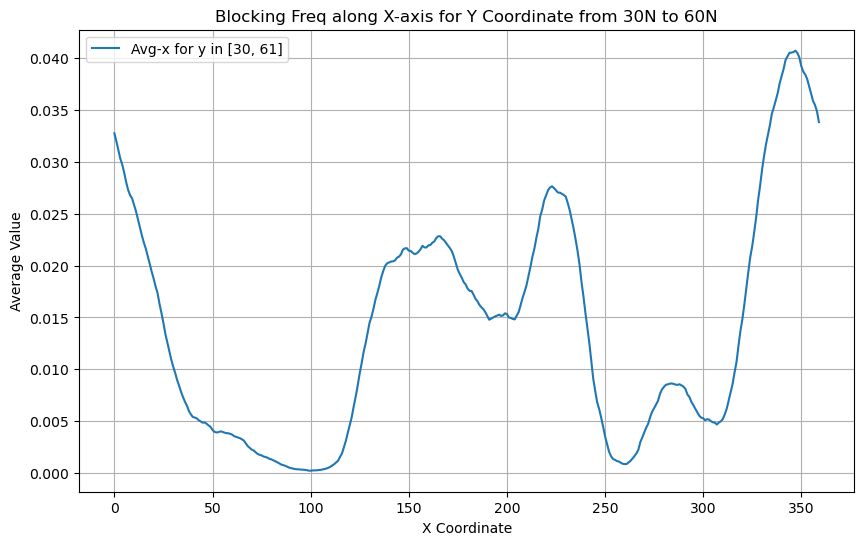

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter 

import numpy as np

BlockingFreq = np.load("/depot/wanglei/etc/KenYan_Traffic_Model/Ka Ying Blocking Data/1979_2016 DJF/NH/BlockingFrequency.npy")
global zonal_avg_b



y_range_data = BlockingFreq[30:61, :]

# Calculate the average along the y-axis (axis=0)
zonal_avg_b = np.nanmean(y_range_data, axis=0)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(zonal_avg_b/3430, label='Avg-x for y in [30, 61]')
plt.xlabel('X Coordinate')
plt.ylabel('Average Value')
plt.title('Blocking Freq along X-axis for Y Coordinate from 30N to 60N')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# boolean > 5 days

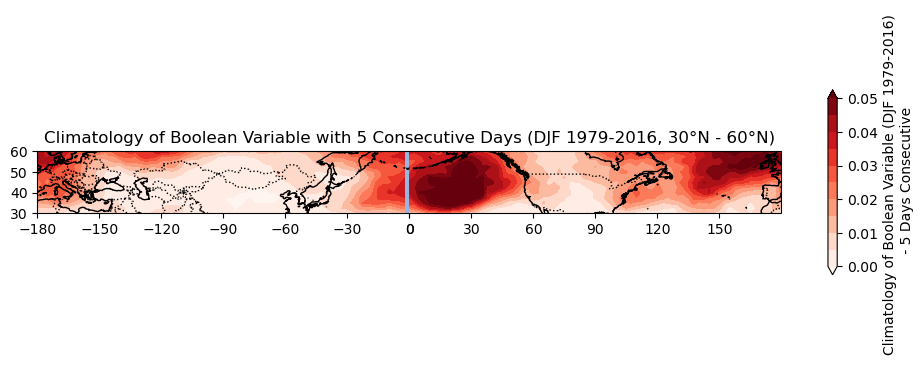

In [6]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the dataset
file_path = '/scratch/negishi/yan481/blockings_era5_DG_M150_T5'
ds = xr.open_dataset(file_path)

# Select the DJF season data from 1979 to 2016
ds_djf = ds.sel(time=((ds['time'].dt.year >= 1979) & (ds['time'].dt.year <= 2016) &
                      ((ds['time'].dt.month == 12) | (ds['time'].dt.month == 1) | (ds['time'].dt.month == 2))))

# Restrict to latitude range 30N to 60N
ds_djf = ds_djf.sel(latitude=slice(30, 60))

# Identify where the boolean variable is 1 for at least 5 consecutive days
def consecutive_days(da, days=5):
    # Create an array where 1 indicates the condition is met and 0 otherwise
    condition = da == 1
    # Use a rolling window to count consecutive days meeting the condition
    rolling_sum = condition.rolling(time=days).sum()
    # Find where the rolling sum equals the number of days (i.e., all days in the window are 1)
    result = rolling_sum >= days
    # Shift the result back by (days - 1) because rolling shifts the window forward
    return result

# Apply the consecutive days filter
consecutive_djf = consecutive_days(ds_djf['__xarray_dataarray_variable__'], days=5)

# Calculate the climatology by averaging over time
climatology = consecutive_djf.mean(dim='time')

# Create a plot centered at 180° longitude
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# Plot the climatology with cmap restricted to 0-0.05 using Reds colormap
contour = ax.contourf(ds_djf['longitude'], ds_djf['latitude'], climatology,
                      transform=ccrs.PlateCarree(), cmap='Reds', levels=np.linspace(0, 0.05, 11), extend='both')

# Add coastlines and features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)

# Add a vertical colorbar, shrink it to make it shorter
cbar = plt.colorbar(contour, orientation='vertical', pad=0.05, shrink=0.4)
cbar.set_label('Climatology of Boolean Variable (DJF 1979-2016) \n 5 Days Consecutive')

# Set latitude and longitude labels
ax.set_xticks(np.arange(-180, 181, 30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(30, 61, 10), crs=ccrs.PlateCarree())

# Set title
ax.set_title('Climatology of Boolean Variable with 5 Consecutive Days (DJF 1979-2016, 30°N - 60°N)')

# Show the plot
plt.show()



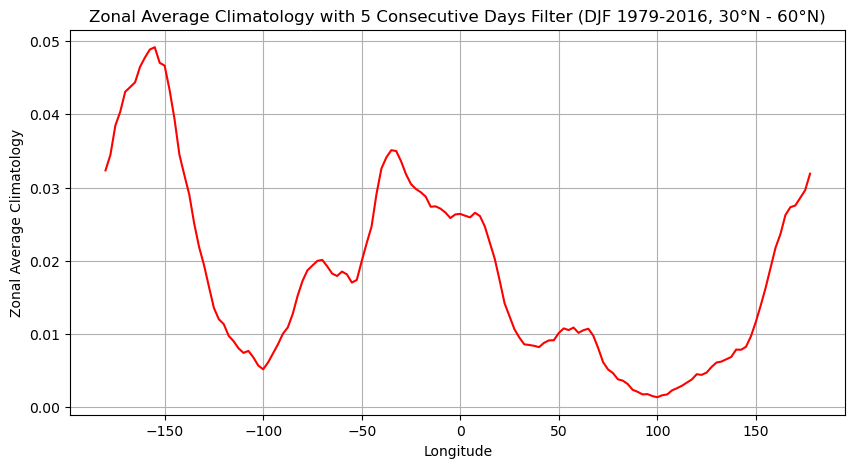

In [7]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
file_path = '/scratch/negishi/yan481/blockings_era5_DG_M150_T5'
ds = xr.open_dataset(file_path)

# Select the DJF season data from 1979 to 2016
ds_djf = ds.sel(time=((ds['time'].dt.year >= 1979) & (ds['time'].dt.year <= 2016) &
                      ((ds['time'].dt.month == 12) | (ds['time'].dt.month == 1) | (ds['time'].dt.month == 2))))

# Restrict to latitude range 30N to 60N
ds_djf = ds_djf.sel(latitude=slice(30, 60))

# Define a function to filter for at least 5 consecutive days
def consecutive_days(da, days=5):
    condition = da == 1
    rolling_sum = condition.rolling(time=days).sum()
    result = rolling_sum >= days
    return result

# Apply the consecutive days filter
consecutive_djf = consecutive_days(ds_djf['__xarray_dataarray_variable__'], days=5)

# Calculate the climatology by averaging over time
climatology = consecutive_djf.mean(dim='time')

# Calculate the zonal average (average over latitude)
zonal_avg = climatology.mean(dim='latitude')

# Create a plot of the zonal average
plt.figure(figsize=(10, 5))

# Plot the zonal average
plt.plot(ds_djf['longitude'], zonal_avg, color='red')

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Zonal Average Climatology')
plt.title('Zonal Average Climatology with 5 Consecutive Days Filter (DJF 1979-2016, 30°N - 60°N)')

# Show grid
plt.grid(True)

# Show the plot
plt.show()


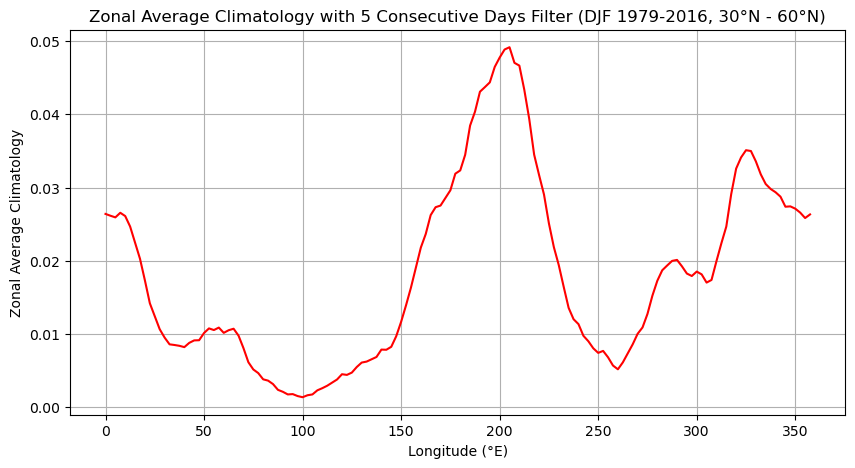

In [9]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
file_path = '/scratch/negishi/yan481/blockings_era5_DG_M150_T5'
ds = xr.open_dataset(file_path)

# Convert longitude from -180° - 180° to 0° - 360°
ds = ds.assign_coords(longitude=(((ds.longitude + 360) % 360)))

# Sort the dataset by the new longitude values (optional but recommended)
ds = ds.sortby('longitude')

# Select the DJF season data from 1979 to 2016
ds_djf = ds.sel(time=((ds['time'].dt.year >= 1979) & (ds['time'].dt.year <= 2016) &
                      ((ds['time'].dt.month == 12) | (ds['time'].dt.month == 1) | (ds['time'].dt.month == 2))))

# Restrict to latitude range 30N to 60N
ds_djf = ds_djf.sel(latitude=slice(30, 60))

# Define a function to filter for at least 5 consecutive days
def consecutive_days(da, days=5):
    condition = da == 1
    rolling_sum = condition.rolling(time=days).sum()
    result = rolling_sum >= days
    return result

# Apply the consecutive days filter
consecutive_djf = consecutive_days(ds_djf['__xarray_dataarray_variable__'], days=5)

# Calculate the climatology by averaging over time
climatology = consecutive_djf.mean(dim='time')

# Calculate the zonal average (average over latitude)
zonal_avg = climatology.mean(dim='latitude')

# Create a plot of the zonal average
plt.figure(figsize=(10, 5))

# Plot the zonal average
plt.plot(ds_djf['longitude'], zonal_avg, color='red')

# Set labels and title
plt.xlabel('Longitude (°E)')
plt.ylabel('Zonal Average Climatology')
plt.title('Zonal Average Climatology with 5 Consecutive Days Filter (DJF 1979-2016, 30°N - 60°N)')

# Show grid
plt.grid(True)

# Show the plot
plt.show()


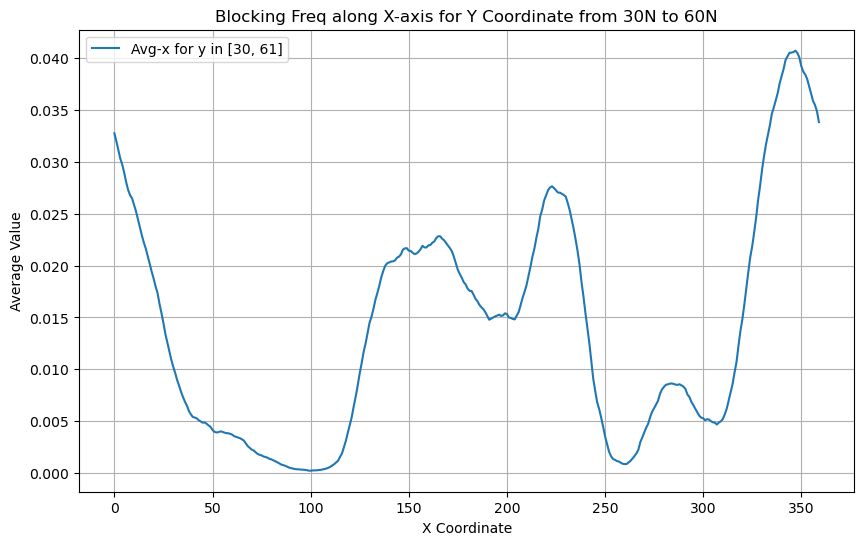

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter 

import numpy as np

BlockingFreq = np.load("/depot/wanglei/etc/KenYan_Traffic_Model/Ka Ying Blocking Data/1979_2016 DJF/NH/BlockingFrequency.npy")
global zonal_avg_b



y_range_data = BlockingFreq[30:61, :]

# Calculate the average along the y-axis (axis=0)
zonal_avg_b = np.nanmean(y_range_data, axis=0)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(zonal_avg_b/3430, label='Avg-x for y in [30, 61]')
plt.xlabel('X Coordinate')
plt.ylabel('Average Value')
plt.title('Blocking Freq along X-axis for Y Coordinate from 30N to 60N')
plt.legend()
plt.grid(True)
plt.show()


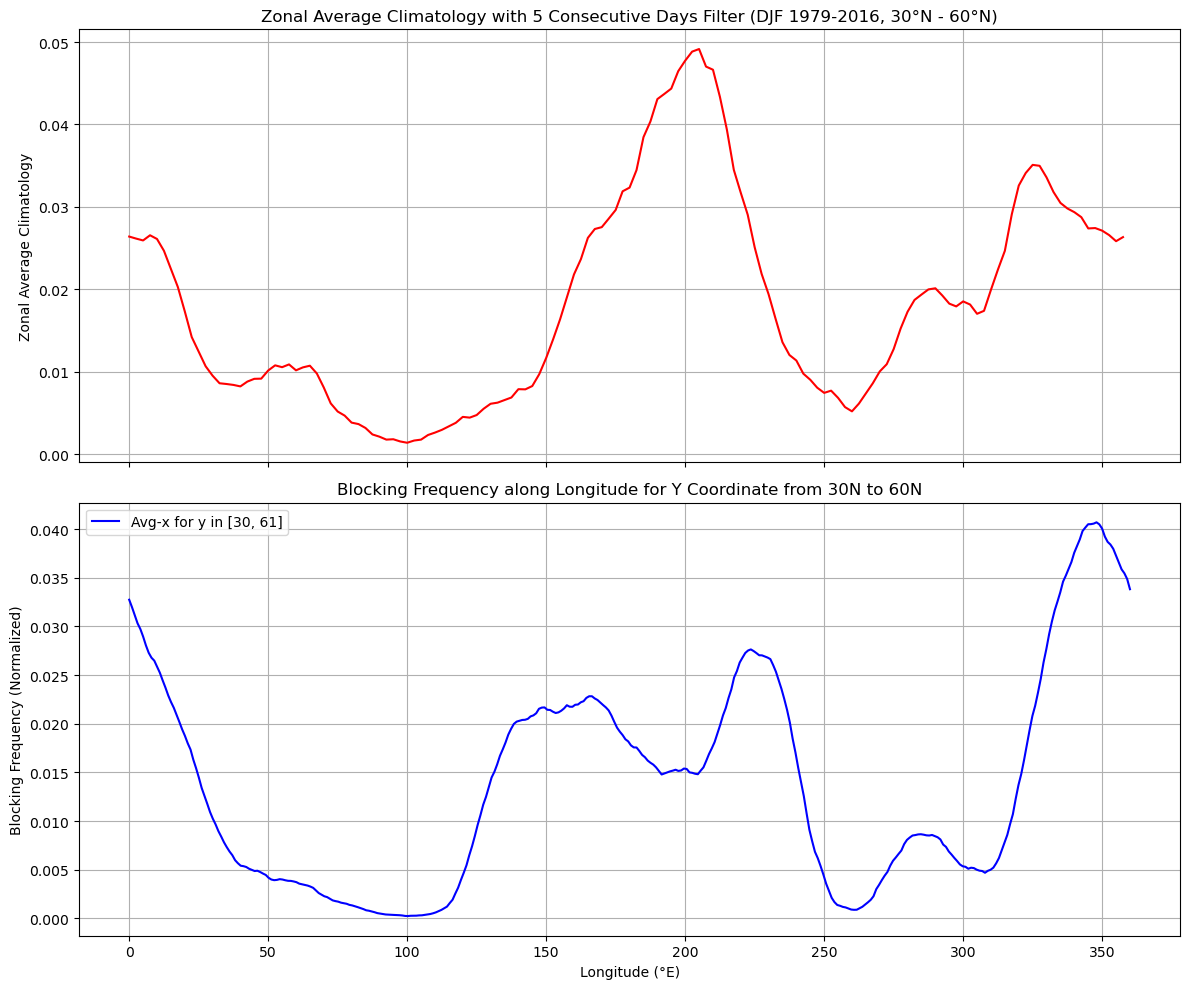

In [10]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
file_path = '/scratch/negishi/yan481/blockings_era5_DG_M150_T5'
ds = xr.open_dataset(file_path)

# Convert longitude from -180° - 180° to 0° - 360°
ds = ds.assign_coords(longitude=(((ds.longitude + 360) % 360)))

# Sort the dataset by the new longitude values (optional but recommended)
ds = ds.sortby('longitude')

# Select the DJF season data from 1979 to 2016
ds_djf = ds.sel(time=((ds['time'].dt.year >= 1979) & (ds['time'].dt.year <= 2016) &
                      ((ds['time'].dt.month == 12) | (ds['time'].dt.month == 1) | (ds['time'].dt.month == 2))))

# Restrict to latitude range 30N to 60N
ds_djf = ds_djf.sel(latitude=slice(30, 60))

# Define a function to filter for at least 5 consecutive days
def consecutive_days(da, days=5):
    condition = da == 1
    rolling_sum = condition.rolling(time=days).sum()
    result = rolling_sum >= days
    return result

# Apply the consecutive days filter
consecutive_djf = consecutive_days(ds_djf['__xarray_dataarray_variable__'], days=5)

# Calculate the climatology by averaging over time
climatology = consecutive_djf.mean(dim='time')

# Calculate the zonal average (average over latitude)
zonal_avg = climatology.mean(dim='latitude')

# Load the BlockingFreq data and calculate zonal average for y-range 30N to 60N
BlockingFreq = np.load("/depot/wanglei/etc/KenYan_Traffic_Model/Ka Ying Blocking Data/1979_2016 DJF/NH/BlockingFrequency.npy")
y_range_data = BlockingFreq[30:61, :]

# Calculate the average along the y-axis (axis=0)
zonal_avg_b = np.nanmean(y_range_data, axis=0)

# Normalize the BlockingFreq zonal average
zonal_avg_b_normalized = zonal_avg_b / 3430

# Create a figure with two subplots
fig, ax1 = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot the zonal average climatology
ax1[0].plot(ds_djf['longitude'], zonal_avg, color='red')
ax1[0].set_ylabel('Zonal Average Climatology')
ax1[0].set_title('Zonal Average Climatology with 5 Consecutive Days Filter (DJF 1979-2016, 30°N - 60°N)')
ax1[0].grid(True)

# Plot the BlockingFreq zonal average (normalized)
ax1[1].plot(np.linspace(0, 360, zonal_avg_b_normalized.shape[0]), zonal_avg_b_normalized, label='Avg-x for y in [30, 61]', color='blue')
ax1[1].set_xlabel('Longitude (°E)')
ax1[1].set_ylabel('Blocking Frequency (Normalized)')
ax1[1].set_title('Blocking Frequency along Longitude for Y Coordinate from 30N to 60N')
ax1[1].grid(True)
ax1[1].legend()

# Show the combined plot
plt.tight_layout()
plt.show()


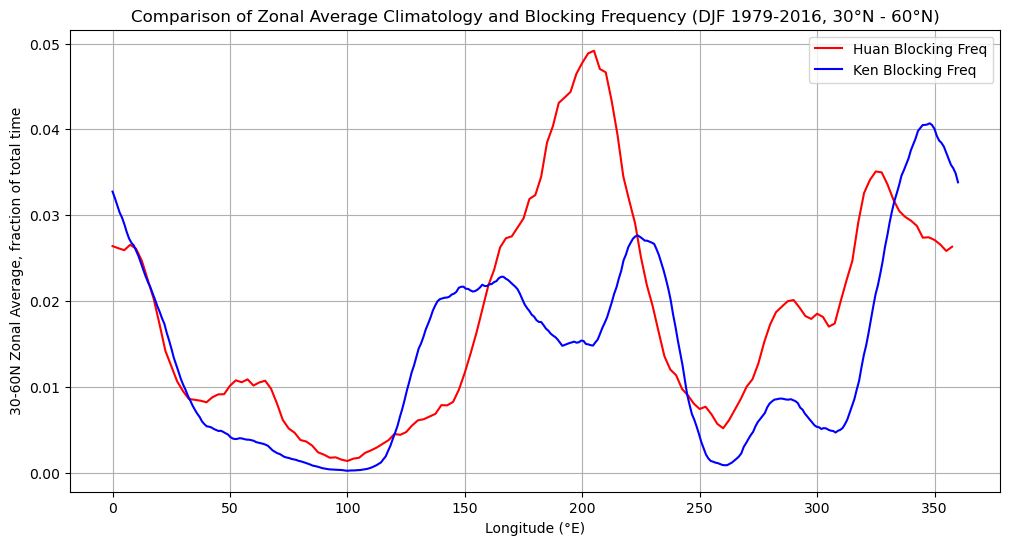

In [13]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
file_path = '/scratch/negishi/yan481/blockings_era5_DG_M150_T5'
ds = xr.open_dataset(file_path)

# Convert longitude from -180° - 180° to 0° - 360°
ds = ds.assign_coords(longitude=(((ds.longitude + 360) % 360)))

# Sort the dataset by the new longitude values (optional but recommended)
ds = ds.sortby('longitude')

# Select the DJF season data from 1979 to 2016
ds_djf = ds.sel(time=((ds['time'].dt.year >= 1979) & (ds['time'].dt.year <= 2016) &
                      ((ds['time'].dt.month == 12) | (ds['time'].dt.month == 1) | (ds['time'].dt.month == 2))))

# Restrict to latitude range 30N to 60N
ds_djf = ds_djf.sel(latitude=slice(30, 60))

# Define a function to filter for at least 5 consecutive days
def consecutive_days(da, days=5):
    condition = da == 1
    rolling_sum = condition.rolling(time=days).sum()
    result = rolling_sum >= days
    return result

# Apply the consecutive days filter
consecutive_djf = consecutive_days(ds_djf['__xarray_dataarray_variable__'], days=5)

# Calculate the climatology by averaging over time
climatology = consecutive_djf.mean(dim='time')

# Calculate the zonal average (average over latitude)
zonal_avg = climatology.mean(dim='latitude')

# Load the BlockingFreq data and calculate zonal average for y-range 30N to 60N
BlockingFreq = np.load("/depot/wanglei/etc/KenYan_Traffic_Model/Ka Ying Blocking Data/1979_2016 DJF/NH/BlockingFrequency.npy")
y_range_data = BlockingFreq[30:61, :]

# Calculate the average along the y-axis (axis=0)
zonal_avg_b = np.nanmean(y_range_data, axis=0)

# Normalize the BlockingFreq zonal average
zonal_avg_b_normalized = zonal_avg_b / 3430

# Create a plot with both datasets
plt.figure(figsize=(12, 6))

# Plot the zonal average climatology
plt.plot(ds_djf['longitude'], zonal_avg, color='red', label='Huan Blocking Freq')

# Plot the BlockingFreq zonal average (normalized)
plt.plot(np.linspace(0, 360, zonal_avg_b_normalized.shape[0]), zonal_avg_b_normalized, label='Ken Blocking Freq', color='blue')

# Set labels, title, and legend
plt.xlabel('Longitude (°E)')
plt.ylabel('30-60N Zonal Average, fraction of total time')
plt.title('Comparison of Zonal Average Climatology and Blocking Frequency (DJF 1979-2016, 30°N - 60°N)')
plt.legend()

# Show grid
plt.grid(True)

# Show the plot
plt.show()
